In [ ]:
import torch
from torch import nn
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import time
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# plot 4 metrics during training progress
def plot_training_progress(results_path):
    data = torch.load(results_path)
    fig, ax1 = plt.subplots()
    plt.plot(data["train_loss"], 'r', label = 'train_loss')
    plt.plot(data["val_loss"], 'm', label = 'val_loss')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')

    ax2=ax1.twinx()
    plt.plot(data["train_accuracy"], 'g', label = 'train_accuracy')
    plt.plot(data["val_accuracy"], 'b', label = 'val_accuracy')
    plt.legend(loc='lower right')
    ax2.set_ylabel('accuracy')

    plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.softmax = nn.Softmax(dim=-2)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        proj_query = self.query_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3]).permute(0,2,1)
        proj_key = self.key_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3])
        attention = self.softmax(torch.bmm(proj_query, proj_key))
        proj_value = self.value_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3])
        out = torch.bmm(proj_value, attention.permute(0,2,1)).view(x.shape)
        out = self.gamma*out + x
        return out, attention

class AttentionResNet(nn.Module):
    def __init__(self, num_classes):
        super(AttentionResNet, self).__init__()
        self.resnet = resnet50(pretrained=True)
        self.self_attention = SelfAttention(self.resnet.fc.in_features)
        self.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x, attention_map = self.self_attention(x)
        
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x, attention_map

def visualize_attention(model, input_image):
    model.eval()
    _, attention_map = model(input_image)
    attention_map = attention_map.detach().cpu().numpy()

    # Normalize attention map for visualization
    max_value = attention_map.max()
    min_value = attention_map.min()
    attention_map = (attention_map - min_value) / (max_value - min_value)

    return attention_map


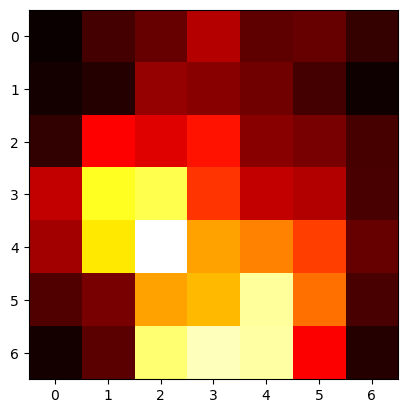

In [5]:
# Create a model and a fake input image
model = AttentionResNet(1000) # change to the number of your classes
input_image = torch.rand((1, 3, 224, 224))

# Get the attention map of the model
attention_map = visualize_attention(model, input_image)

# Reshape attention map for visualization
attention_map = attention_map.reshape((attention_map.shape[1], int(attention_map.shape[2]**0.5), int(attention_map.shape[2]**0.5)))

# Plot the attention map
plt.imshow(attention_map[0,:,:], cmap='hot')
plt.show()


In [ ]:

    
# time recording start
start_time = time.time()

# 定义数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
dataset = ImageFolder(root="./MO_106/", transform=transform)

# 数据集分割为训练集、验证集和测试集
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Training loop
num_epochs = 10
batch_size = 128
lr = 0.00005

# 分别创建训练集、验证集和测试集的 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# 定义模型
model = AttentionResNet(num_classes=106)
model = model.to(device)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

# 训练模型
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/10], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # 在每个 epoch 后使用验证集评估模型
    model.eval()
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)
    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"attention_resnet_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)
        
# 所有训练完成后，使用测试集进行最后的评估
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test accuracy: {correct / total * 100}%')

# Post-training attention visualization
# Use a batch from your test set as an example
example_images, example_labels = next(iter(test_loader))
example_images = example_images.to(device)

# Get the attention map of the model
attention_map = visualize_attention(model, example_images)

# Reshape attention map for visualization
attention_map = attention_map.reshape((attention_map.shape[0], attention_map.shape[1], int(attention_map.shape[2]**0.5), int(attention_map.shape[2]**0.5)))

# Plot the attention map of the first image in the batch
plt.imshow(attention_map[0,0,:,:], cmap='hot')
plt.show()